In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, MobileNetV2, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os

In [15]:
# ==== SETUP ====
img_size = (224, 260)
batch_size = 32
train_dir = 'C:/Users/Sinta/Documents/Larskar AI/Capstone/prediksi_penyakit_tanaman/dataset/data_wheat/train'
val_dir = 'C:/Users/Sinta/Documents/Larskar AI/Capstone/prediksi_penyakit_tanaman/dataset/data_wheat/valid'
test_dir = 'C:/Users/Sinta/Documents/Larskar AI/Capstone/prediksi_penyakit_tanaman/dataset/data_wheat/test'

# ==== KELAS ====
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)

# ==== DATA AUGMENTATION ====
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

Found 13104 images belonging to 15 classes.
Found 300 images belonging to 15 classes.
Found 750 images belonging to 15 classes.


In [16]:
# ==== HITUNG CLASS WEIGHTS ====
all_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights = dict(enumerate(class_weights))

In [17]:
# ==== BUILD MODEL (EfficientNetB0 sebagai alternatif MobileNetV2) ====
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=img_size + (3,)
)
base_model.trainable = False


model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

16705208/16705208 [==============================] - 8s 0us/step


In [18]:
# ==== COMPILE ====
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ==== CALLBACKS ====
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

In [19]:

# ==== TRAIN ====
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/30
410/410 [==============================] - 2967s 7s/step - loss: 2.7306 - accuracy: 0.0669 - val_loss: 2.7091 - val_accuracy: 0.0633 - lr: 1.0000e-05
Epoch 2/30
273/410 [==================>...........] - ETA: 9:37 - loss: 2.7253 - accuracy: 0.0659

KeyboardInterrupt: 

In [18]:

# ==== FINE-TUNING ====
# Unfreeze bagian atas MobileNetV2
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

In [19]:
# Compile ulang dengan learning rate lebih kecil
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Lanjutkan training
history_finetune = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
)

Epoch 1/15
410/410 [==============================] - 995s 2s/step - loss: 1.3962 - accuracy: 0.5730 - val_loss: 2.0476 - val_accuracy: 0.6367
Epoch 2/15
410/410 [==============================] - 987s 2s/step - loss: 1.0961 - accuracy: 0.6503 - val_loss: 2.1864 - val_accuracy: 0.6567
Epoch 3/15
410/410 [==============================] - 998s 2s/step - loss: 1.0446 - accuracy: 0.6667 - val_loss: 2.0984 - val_accuracy: 0.6533
Epoch 4/15
410/410 [==============================] - 1004s 2s/step - loss: 0.9863 - accuracy: 0.6848 - val_loss: 2.1921 - val_accuracy: 0.6700
Epoch 5/15
410/410 [==============================] - 990s 2s/step - loss: 0.9451 - accuracy: 0.6926 - val_loss: 1.9813 - val_accuracy: 0.6600
Epoch 6/15
410/410 [==============================] - 985s 2s/step - loss: 0.9163 - accuracy: 0.7047 - val_loss: 1.9212 - val_accuracy: 0.6833
Epoch 7/15
410/410 [==============================] - 1816s 4s/step - loss: 0.8829 - accuracy: 0.7096 - val_loss: 1.9110 - val_accuracy: 0.66

In [ ]:
# ==== EVALUASI ====
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")

# ==== SIMPAN MODEL ====
model.save('C:/Users/Sinta/Documents/Larskar AI/Capstone/prediksi_penyakit_tanaman/dataset/models/predict_model_disease_wheat.h5')


24/24 [==============================] - 56s 2s/step - loss: 1.5268 - accuracy: 0.7333

Test Accuracy: 0.7333


24/24 [==============================] - 47s 2s/step
                           precision    recall  f1-score   support

               aphid_test       0.80      0.80      0.80        50
          black_rust_test       0.73      0.48      0.58        50
               blast_test       0.71      1.00      0.83        50
          brown_rust_test       0.64      0.70      0.67        50
     common_root_rot_test       0.78      0.94      0.85        50
fusarium_head_blight_test       0.89      0.68      0.77        50
             healthy_test       0.20      0.06      0.09        50
         leaf_blight_test       0.75      0.72      0.73        50
              mildew_test       0.89      0.78      0.83        50
                mite_test       0.87      0.54      0.67        50
            septoria_test       0.89      0.98      0.93        50
                smut_test       0.83      0.96      0.89        50
            stem_fly_test       0.98      0.84      0.90        50
        

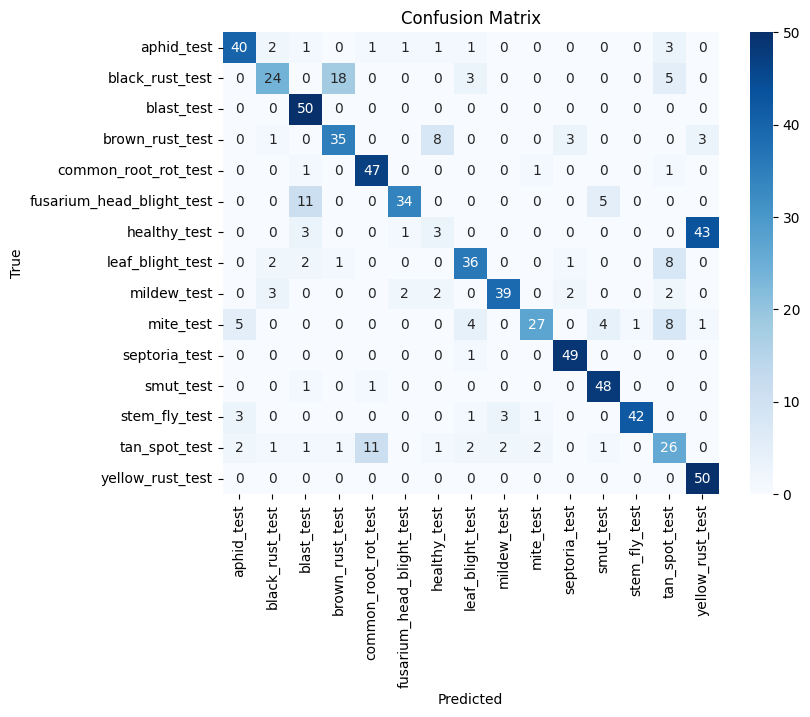

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Prediksi
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()